In [1]:
import os, sys
import pandas as pd
import numpy as np
from datetime import datetime
from dotenv import load_dotenv
load_dotenv()

PROJECT_PATH = os.getenv('PROJECT_DIR')
sys.path.append(PROJECT_PATH)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# visualization
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# custom modules
from src.data_ingestion.iex_data import IexDataFetcher
from src.data_ingestion.weather_data import WeatherDataFetcher
from src.feature_engineering.build_features import FeatureEngineering
from src.model_building.train_model import ModelTraining
from src.model_building.eval_model import ModelEvaluator
from src.utils import *
from config.paths import *

In [3]:
# creating instances
iex_data = IexDataFetcher()
weather_data = WeatherDataFetcher()

featured_data = FeatureEngineering(PROJECT_PATH) 
build_model = ModelTraining(PROJECT_PATH)

### Data Ingestion

In [4]:
dam = iex_data._get_processed_data('dam')
rtm = iex_data._get_processed_data('rtm')
# weather = weather_data._get_processed_weather('weather')
# wind = weather_data._get_processed_weather('wind')
# hydro = weather_data._get_processed_weather('hydro')
# solar = weather_data._get_processed_weather('solar')

dam data is already updated up to:  2024-01-14 23:45:00
rtm data updated up to:  14-01-2024 02:45


In [5]:
weather = load_pickle(PROCESSED_DATA_PATH, 'weather_data')
wind = load_pickle(PROCESSED_DATA_PATH, 'wind_data')
hydro = load_pickle(PROCESSED_DATA_PATH, 'hydro_data')
solar = load_pickle(PROCESSED_DATA_PATH, 'solar_data')

### Feature Engineering

In [6]:
rtm = featured_data.shift_date(rtm, 1) 
weather = featured_data.shift_date(weather, -1)
hydro = featured_data.shift_date(hydro, -1) 
solar = featured_data.shift_date(solar, -1) 
wind = featured_data.shift_date(wind, -1)

data = featured_data.merge_dataframes([dam, rtm, weather, hydro, solar, wind])

In [7]:
training_data = featured_data._get_features(data, weather, data_type = 'dam')

In [8]:
save_pickle(training_data, PROCESSED_DATA_PATH, 'training_data')

### Model Building

In [11]:
training_data = load_pickle(PROCESSED_DATA_PATH, 'training_data')

In [12]:
# Set the desired cutoff dates
training_upto = training_data.iloc[int(training_data.shape[0]*0.9)]['datetime'].strftime('%Y-%m-%d')      # 80% data for training
validation_upto = training_data.iloc[int(training_data.shape[0]*0.95)]['datetime'].strftime('%Y-%m-%d')        # last day data for testing

# Split the data
X_train, y_train, X_valid, y_valid, X_test, y_test = build_model._split_data(training_data, training_upto, validation_upto)

In [13]:
# trail and error
n_trials = 20
n_features = 20

In [14]:
best_features, best_params = build_model._features_n_params(X_train, y_train, X_valid, y_valid, n_trials, n_features)

[I 2024-01-14 02:13:07,886] A new study created in memory with name: no-name-13314149-6dac-4d65-88ca-89e3e2914d57
[I 2024-01-14 02:13:08,477] Trial 0 finished with value: 17.94 and parameters: {'n_estimators': 500, 'lambda_l1': 70.0, 'lambda_l2': 85.0, 'num_leaves': 4850, 'min_data_in_leaf': 6700, 'max_bin': 269, 'feature_fraction': 0.3, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 2, 'min_gain_to_split': 11.894001551471073, 'max_depth': 4, 'learning_rate': 0.08}. Best is trial 0 with value: 17.94.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] min_gain_to_split is set=7.792121249506133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.792121249506133
[LightGBM] [Warning] lambda_l1 is set=85.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85.0


[I 2024-01-14 02:13:08,802] Trial 1 finished with value: 19.12 and parameters: {'n_estimators': 100, 'lambda_l1': 85.0, 'lambda_l2': 5.0, 'num_leaves': 9400, 'min_data_in_leaf': 9100, 'max_bin': 259, 'feature_fraction': 0.4, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 4, 'min_gain_to_split': 7.792121249506133, 'max_depth': 8, 'learning_rate': 0.21000000000000002}. Best is trial 0 with value: 17.94.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] lambda_l2 is set=40.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=6.024635308892415, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.024635308892415
[LightGBM] [Warning] lambda_l1 is set=25.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25.0


[I 2024-01-14 02:13:09,150] Trial 2 finished with value: 20.71 and parameters: {'n_estimators': 300, 'lambda_l1': 25.0, 'lambda_l2': 40.0, 'num_leaves': 8300, 'min_data_in_leaf': 7100, 'max_bin': 294, 'feature_fraction': 0.5, 'bagging_fraction': 0.3, 'bagging_freq': 4, 'min_gain_to_split': 6.024635308892415, 'max_depth': 3, 'learning_rate': 0.09999999999999999}. Best is trial 0 with value: 17.94.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] lambda_l2 is set=70.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.0
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=7.121287929059681, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.121287929059681
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0


[I 2024-01-14 02:13:09,438] Trial 3 finished with value: 19.45 and parameters: {'n_estimators': 900, 'lambda_l1': 0.0, 'lambda_l2': 70.0, 'num_leaves': 750, 'min_data_in_leaf': 5300, 'max_bin': 291, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'min_gain_to_split': 7.121287929059681, 'max_depth': 12, 'learning_rate': 0.26}. Best is trial 0 with value: 17.94.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6500
[LightGBM] [Warning] lambda_l2 is set=95.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=4.502332694737403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.502332694737403
[LightGBM] [Warning] lambda_l1 is set=55.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55.0


[I 2024-01-14 02:13:09,962] Trial 4 finished with value: 17.67 and parameters: {'n_estimators': 100, 'lambda_l1': 55.0, 'lambda_l2': 95.0, 'num_leaves': 6250, 'min_data_in_leaf': 6500, 'max_bin': 293, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'min_gain_to_split': 4.502332694737403, 'max_depth': 9, 'learning_rate': 0.06999999999999999}. Best is trial 4 with value: 17.67.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] lambda_l2 is set=100.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] min_gain_to_split is set=14.817938471060545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.817938471060545
[LightGBM] [Warning] lambda_l1 is set=35.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35.0


[I 2024-01-14 02:13:10,464] Trial 5 finished with value: 17.87 and parameters: {'n_estimators': 200, 'lambda_l1': 35.0, 'lambda_l2': 100.0, 'num_leaves': 2550, 'min_data_in_leaf': 3000, 'max_bin': 217, 'feature_fraction': 0.8, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 2, 'min_gain_to_split': 14.817938471060545, 'max_depth': 12, 'learning_rate': 0.26}. Best is trial 4 with value: 17.67.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] lambda_l2 is set=70.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=12.816913360831006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.816913360831006
[LightGBM] [Warning] lambda_l1 is set=30.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30.0


[I 2024-01-14 02:13:10,961] Trial 6 finished with value: 19.1 and parameters: {'n_estimators': 300, 'lambda_l1': 30.0, 'lambda_l2': 70.0, 'num_leaves': 2600, 'min_data_in_leaf': 7100, 'max_bin': 205, 'feature_fraction': 1.0, 'bagging_fraction': 0.5, 'bagging_freq': 6, 'min_gain_to_split': 12.816913360831006, 'max_depth': 4, 'learning_rate': 0.02}. Best is trial 4 with value: 17.67.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] lambda_l2 is set=95.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=13.858337299392547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.858337299392547
[LightGBM] [Warning] lambda_l1 is set=95.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95.0


[I 2024-01-14 02:13:11,716] Trial 7 finished with value: 17.16 and parameters: {'n_estimators': 800, 'lambda_l1': 95.0, 'lambda_l2': 95.0, 'num_leaves': 2000, 'min_data_in_leaf': 1300, 'max_bin': 236, 'feature_fraction': 0.5, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 3, 'min_gain_to_split': 13.858337299392547, 'max_depth': 13, 'learning_rate': 0.05}. Best is trial 7 with value: 17.16.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=4.416952978664553, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.416952978664553
[LightGBM] [Warning] lambda_l1 is set=20.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20.0


[I 2024-01-14 02:13:12,040] Trial 8 finished with value: 17.83 and parameters: {'n_estimators': 300, 'lambda_l1': 20.0, 'lambda_l2': 10.0, 'num_leaves': 8750, 'min_data_in_leaf': 2200, 'max_bin': 228, 'feature_fraction': 0.8, 'bagging_fraction': 0.3, 'bagging_freq': 7, 'min_gain_to_split': 4.416952978664553, 'max_depth': 8, 'learning_rate': 0.25}. Best is trial 7 with value: 17.16.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=7900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7900
[LightGBM] [Warning] lambda_l2 is set=15.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=10.46892936240328, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.46892936240328
[LightGBM] [Warning] lambda_l1 is set=100.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100.0


[I 2024-01-14 02:13:12,280] Trial 9 finished with value: 21.88 and parameters: {'n_estimators': 500, 'lambda_l1': 100.0, 'lambda_l2': 15.0, 'num_leaves': 800, 'min_data_in_leaf': 7900, 'max_bin': 287, 'feature_fraction': 0.5, 'bagging_fraction': 0.3, 'bagging_freq': 3, 'min_gain_to_split': 10.46892936240328, 'max_depth': 9, 'learning_rate': 0.22}. Best is trial 7 with value: 17.16.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] lambda_l2 is set=50.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=0.9247155584768443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9247155584768443
[LightGBM] [Warning] lambda_l1 is set=100.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100.0


[I 2024-01-14 02:13:12,908] Trial 10 finished with value: 16.83 and parameters: {'n_estimators': 900, 'lambda_l1': 100.0, 'lambda_l2': 50.0, 'num_leaves': 4100, 'min_data_in_leaf': 700, 'max_bin': 240, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'min_gain_to_split': 0.9247155584768443, 'max_depth': 15, 'learning_rate': 0.15000000000000002}. Best is trial 10 with value: 16.83.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=45.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=2.634358563674601, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.634358563674601
[LightGBM] [Warning] lambda_l1 is set=100.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100.0


[I 2024-01-14 02:13:13,784] Trial 11 finished with value: 17.03 and parameters: {'n_estimators': 900, 'lambda_l1': 100.0, 'lambda_l2': 45.0, 'num_leaves': 3950, 'min_data_in_leaf': 500, 'max_bin': 235, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'min_gain_to_split': 2.634358563674601, 'max_depth': 15, 'learning_rate': 0.15000000000000002}. Best is trial 10 with value: 16.83.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=40.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=0.5498813862692068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5498813862692068
[LightGBM] [Warning] lambda_l1 is set=75.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75.0


[I 2024-01-14 02:13:14,909] Trial 12 finished with value: 17.39 and parameters: {'n_estimators': 1000, 'lambda_l1': 75.0, 'lambda_l2': 40.0, 'num_leaves': 5150, 'min_data_in_leaf': 200, 'max_bin': 243, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'min_gain_to_split': 0.5498813862692068, 'max_depth': 15, 'learning_rate': 0.15000000000000002}. Best is trial 10 with value: 16.83.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] lambda_l2 is set=55.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=0.014907310689420528, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014907310689420528
[LightGBM] [Warning] lambda_l1 is set=60.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60.0


[I 2024-01-14 02:13:15,390] Trial 13 finished with value: 17.76 and parameters: {'n_estimators': 700, 'lambda_l1': 60.0, 'lambda_l2': 55.0, 'num_leaves': 4350, 'min_data_in_leaf': 3500, 'max_bin': 255, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'min_gain_to_split': 0.014907310689420528, 'max_depth': 15, 'learning_rate': 0.15000000000000002}. Best is trial 10 with value: 16.83.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] lambda_l2 is set=30.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=2.4657687950211047, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4657687950211047
[LightGBM] [Warning] lambda_l1 is set=85.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85.0


[I 2024-01-14 02:13:16,050] Trial 14 finished with value: 17.03 and parameters: {'n_estimators': 700, 'lambda_l1': 85.0, 'lambda_l2': 30.0, 'num_leaves': 6450, 'min_data_in_leaf': 700, 'max_bin': 224, 'feature_fraction': 1.0, 'bagging_fraction': 0.8, 'bagging_freq': 2, 'min_gain_to_split': 2.4657687950211047, 'max_depth': 13, 'learning_rate': 0.18000000000000002}. Best is trial 10 with value: 16.83.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] lambda_l2 is set=60.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=2.780388225907976, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.780388225907976
[LightGBM] [Warning] lambda_l1 is set=100.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100.0


[I 2024-01-14 02:13:16,585] Trial 15 finished with value: 17.65 and parameters: {'n_estimators': 1000, 'lambda_l1': 100.0, 'lambda_l2': 60.0, 'num_leaves': 3750, 'min_data_in_leaf': 4200, 'max_bin': 270, 'feature_fraction': 0.7, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 3, 'min_gain_to_split': 2.780388225907976, 'max_depth': 15, 'learning_rate': 0.12}. Best is trial 10 with value: 16.83.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] lambda_l2 is set=25.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=1.909297721351837, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.909297721351837
[LightGBM] [Warning] lambda_l1 is set=85.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85.0


[I 2024-01-14 02:13:17,398] Trial 16 finished with value: 17.98 and parameters: {'n_estimators': 800, 'lambda_l1': 85.0, 'lambda_l2': 25.0, 'num_leaves': 6650, 'min_data_in_leaf': 1900, 'max_bin': 243, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'min_gain_to_split': 1.909297721351837, 'max_depth': 11, 'learning_rate': 0.18000000000000002}. Best is trial 10 with value: 16.83.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] lambda_l2 is set=45.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.0
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=4.34383582968022, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.34383582968022
[LightGBM] [Warning] lambda_l1 is set=45.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45.0


[I 2024-01-14 02:13:18,071] Trial 17 finished with value: 17.39 and parameters: {'n_estimators': 600, 'lambda_l1': 45.0, 'lambda_l2': 45.0, 'num_leaves': 3450, 'min_data_in_leaf': 4900, 'max_bin': 207, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.8, 'bagging_freq': 2, 'min_gain_to_split': 4.34383582968022, 'max_depth': 6, 'learning_rate': 0.13}. Best is trial 10 with value: 16.83.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] lambda_l2 is set=65.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=9.417647963933014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.417647963933014
[LightGBM] [Warning] lambda_l1 is set=70.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70.0


[I 2024-01-14 02:13:18,670] Trial 18 finished with value: 18.12 and parameters: {'n_estimators': 900, 'lambda_l1': 70.0, 'lambda_l2': 65.0, 'num_leaves': 5550, 'min_data_in_leaf': 2600, 'max_bin': 233, 'feature_fraction': 0.7, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'min_gain_to_split': 9.417647963933014, 'max_depth': 14, 'learning_rate': 0.3}. Best is trial 10 with value: 16.83.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] lambda_l2 is set=25.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=1.368651164951953, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.368651164951953
[LightGBM] [Warning] lambda_l1 is set=90.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90.0


[I 2024-01-14 02:13:19,566] Trial 19 finished with value: 17.28 and parameters: {'n_estimators': 900, 'lambda_l1': 90.0, 'lambda_l2': 25.0, 'num_leaves': 7500, 'min_data_in_leaf': 1200, 'max_bin': 215, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.7, 'bagging_freq': 3, 'min_gain_to_split': 1.368651164951953, 'max_depth': 11, 'learning_rate': 0.18000000000000002}. Best is trial 10 with value: 16.83.




Best MAPE achieved:  16.83


### Model Training

In [15]:
# training upto this date
training_upto = training_data[::96]['datetime'].iloc[-1].strftime('%Y-%m-%d')
validation_upto = datetime.now().date().strftime('%Y-%m-%d')
X_train, y_train, X_test, y_test, X_valid, y_valid = build_model._split_data(training_data, training_upto, validation_upto)

In [16]:
model = build_model._train_model(X_train, y_train, best_params, best_features, objective = 'regression')

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] lambda_l2 is set=50.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=0.9247155584768443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9247155584768443
[LightGBM] [Warning] lambda_l1 is set=100.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100.0


In [18]:
save_pickle(model, models_path, 'dam_forecast')

In [21]:
lower_model = build_model._train_model(X_train, y_train, best_params, best_features, objective = 'quantile', alpha = 0.1)

In [22]:
save_pickle(lower_model, models_path, 'dam_lower')

In [23]:
upper_model = build_model._train_model(X_train, y_train, best_params, best_features, objective = 'quantile', alpha = 0.9)

In [24]:
save_pickle(upper_model, models_path, 'dam_upper')

### Model Evaluation

In [25]:
evaluator = ModelEvaluator(model, best_features)

Evaluating on train data:
MAPE: 7.430000000000001


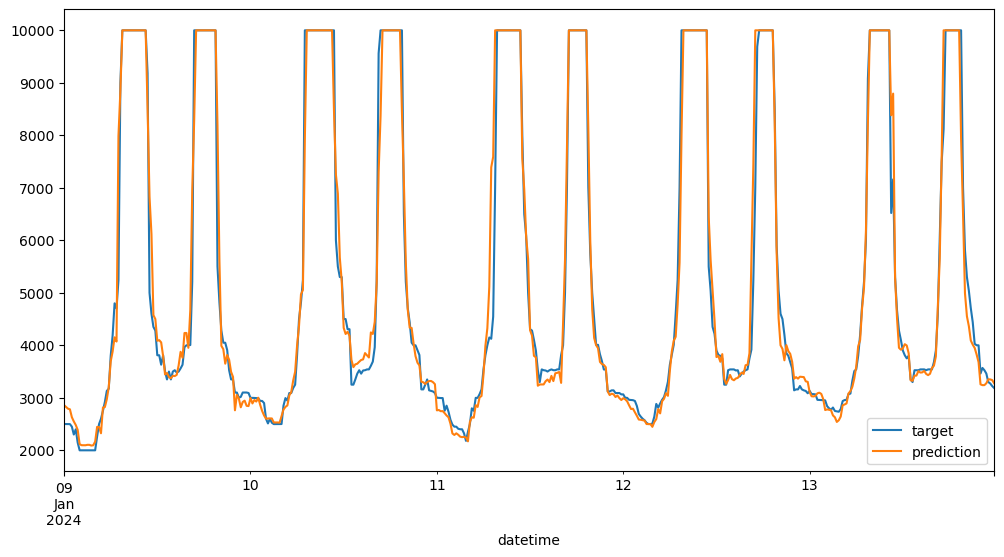

In [26]:
evaluator.evaluate_on_data(X_train, y_train, 'train', 5)

Evaluating on test data:
MAPE: 13.780000000000001


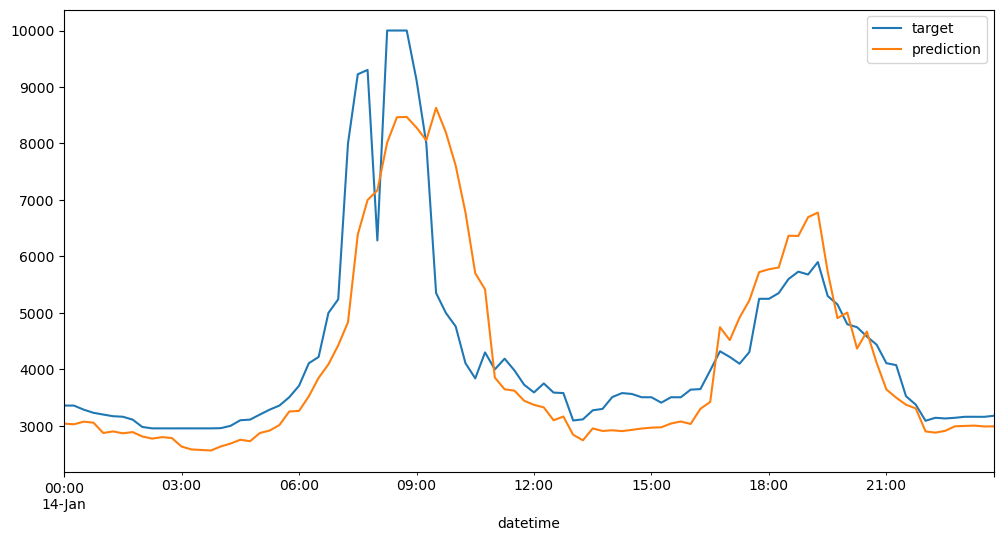

In [27]:
evaluator.evaluate_on_data(X_test, y_test, 'test', 1)